# Hidden Discrete Markov Models

### Importing Required Libraries

In [42]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [43]:
# Parameters for our distribution p(observation|latent). These will be long and
# randomized
np.random.seed(2)
obs_dim = 3
GAUSS_MEANS = [np.array([1.0, -1.0, 0.2]),
               np.array([0.6, 1.1, 1.0]),
               np.array([1.3, 1.0, 1.2])]
GAUSS_COVS = [np.eye(obs_dim) / 4]*3
PI = np.array([0.7, 0.2, 0.1])
A_MAT = np.array([[0.9, 0.0, 0.1], [0.0, 0.9, 0.1], [0.1, 0.3, 0.6]])

def generate_latent_and_observations(n_observations: int) -> Tuple[np.ndarray, np.ndarray]:
    """Generate a sample set of observations along with the true latents.

    Args:
        n_observations: Number of observations to generate.

    Returns:
        Sequence of latent states and observations.
    """
    # Placeholders.
    latents = np.zeros((n_observations + 1, len(PI)))
    observations = np.zeros((n_observations, len(GAUSS_MEANS[0])))

    # Start with the initial latent state
    latents[0, np.random.choice(np.arange(len(PI)), p=PI)] = 1

    # Fill out the rest.
    for i in range(n_observations):
        latents[i+1, np.random.choice(np.arange(len(PI)), p=A_MAT[np.argmax(latents[i])])] = 1
        cur_state = np.argmax(latents[i+1])
        observations[i] = np.random.multivariate_normal(GAUSS_MEANS[cur_state], GAUSS_COVS[cur_state])

    return latents, observations

def observation_probability(latent_index: int, observation: np.ndarray) -> float:
    """Given an observation and corresponding latent state, evaluate the likelihood.

    Args:
        latent_index: Index of latent state encoding.
        observation: Observation at current time step.

    Returns:
        Likelihood p(observation|latent).
    """
    # Let's keep things somewhat 'simple' by making our distribution a sum of Gaussians
    return stats.multivariate_normal.pdf(observation, mean = GAUSS_MEANS[latent_index], cov = GAUSS_COVS[latent_index])

# Generate the data for our study.
true_latents, observations = generate_latent_and_observations(1000)

## Emotion Study

Your friend in the sociology department is studying the effects of social media habits on emotions. They’ve run an experiment placing FMRI sensors on the brains of several volunteers as they scroll through the internet. The volunteers can be in one of three states: happy, angry, or neutral. They’ve used the following one-hot encoding:

$$
\mathbf{z}_{\text{happy}} = \begin{bmatrix}1\\0\\0\end{bmatrix}, \quad
\mathbf{z}_{\text{angry}} = \begin{bmatrix}0\\1\\0\end{bmatrix}, \quad
\mathbf{z}_{\text{neutral}} = \begin{bmatrix}0\\0\\1\end{bmatrix}.
$$

Given that encoding, they also have a very good model for the probability of observing a specific FMRI scan $ \mathbf{x}_t $ given the state $ \mathbf{z}_t $. They have already done the favor of uploading it to your notebook as the function `observation_probability`. They also have a time series $ \{\mathbf{x}_1, \dots, \mathbf{x}_T\} $ for a volunteer that spends a lot of time on social media. For this volunteer, they know that the transition matrix looks like:

$$
A = 
\begin{bmatrix}
0.9 & 0.0 & 0.1 \\
0.0 & 0.9 & 0.1 \\
0.1 & 0.3 & 0.6
\end{bmatrix},
$$

and having observed the volunteer enter they have a pretty good guess at the initial state:

$$
\boldsymbol{\pi} = 
\begin{bmatrix}
0.7 \\
0.2 \\
0.1
\end{bmatrix}.
$$

They would like to know:

- **What is the most likely emotional state at each time step** (i.e. max of $p(z_t | \mathbf{x}_{1:t})$ or $p(z_t | \mathbf{x}_{1:T})$)?
- **What is the most likely sequence of emotional states expressed by the volunteer?**


### Part I: Implementing the Viterbi Algorithm for a discrete Hidden Markov Model.

To answer your friend’s questions, you will need to solve for the transition matrix governing the discrete HMM and calculate the most likely series of latent states. This will require:

1. Implementing the calculation for $\hat{\alpha}(z_t)$  
2. Implementing the calculation for $\hat{\beta}(z_t)$  
3. Implementing the calculation for $p(z_t \mid \mathbf{x}_{1:t})$, $p(z_t \mid \mathbf{x}_{1:T})$, $p(z_{1:T} \mid \mathbf{x}_{1:T})$  
4. Implementing the Viterbi algorithm.


In [44]:
def one_hot_encode(state_index: int, dim_z: int) -> np.ndarray:
    """Return the one hot encoding for a latent state.

    Args:
        state_index: Latent state index. Counts from zero.
        dim_z: Number of latent states.

    Returns:
        One-hot encoding.
    """
    z_encode = np.zeros(dim_z)
    z_encode[state_index] = 1
    return z_encode


class DiscreteHMM:
    """Class that implements a discrete HMM.

    Args:
        pi: Initial guess for the vector pi.
        transition_matrix: Initial guess for the transition matrix.
    """
    def __init__(self, pi: np.ndarray, transition_matrix: np.ndarray):
        """Initialize our class."""
        # Save the initial guess.
        self.pi = pi
        self.transition_matrix = transition_matrix

        # Some useful variables.
        self.dim_z = len(self.pi)

    def calc_alpha_hat(self, observations: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Given the observations, calculate the normalized forward pass.

        Args:
            observations: Observations for each time step.

        Returns:
            Normalized forward pass for each time step and latent state and
            normalization constants.
        """
        # Initialize a placeholder.
        alpha_hat = np.zeros((len(observations) + 1, self.dim_z))
        c_t = np.zeros((len(observations) + 1))

        # t=0 value. Consider c_0 = 1 for simplicity.
        alpha_hat[0] = self.pi
        c_t[0] = 1

        # Recurse forward.
        for t in range(1, len(alpha_hat)):
            for i in range(self.dim_z):
                # sum over previous states
                for j in range(self.dim_z):
                    alpha_hat[t, i] += alpha_hat[t-1, j] * self.transition_matrix[j, i]
                # now multiply by emission for state i at time t
                alpha_hat[t, i] *= observation_probability(i, observations[t-1])

            # normalize
            c_t[t] = np.sum(alpha_hat[t])
            alpha_hat[t] /= c_t[t]

        return alpha_hat, c_t

    def calc_beta_hat(self, observations: np.ndarray) -> np.ndarray:
        """Given the observations, calculate the normalized backward pass.

        Args:
            observations: Observations for each time step.

        Returns:
            Normalized backward pass for each time step.
        """
        # Initialize a placeholder.
        beta_hat = np.zeros((len(observations) + 1, self.dim_z))

        # Get the c_t values
        _, c_t = self.calc_alpha_hat(observations)

        # t=0 value.
        beta_hat[-1] = np.ones(self.dim_z, dtype=float)

        # Recurse backward.
        for t in range(len(beta_hat)-2, -1, -1):
            for i in range(self.dim_z):
                for j in range(self.dim_z):
                    beta_hat[t,i] +=  beta_hat[t + 1,j] * observation_probability(j, observations[t]) * self.transition_matrix[i, j]
            beta_hat[t] /= c_t[t + 1]

        return beta_hat

    def p_zt_xt(self, observations: np.ndarray, alpha_hat: np.ndarray,
                beta_hat: np.ndarray, c_t: np.ndarray):
        """Calculate p(z_t|x_{1:t}) for all t.

        Args:
            observations: Observations for each time step.
            alpha_hat: Normalized forward pass output.
            beta_hat: Normalized backward pass output.
            c_t: Normalization constants for forward and backward pass.

        Returns:
            Value of p(z_t|x_{1:t}) for each time step and latent state index.

        Notes:
            You may not need all of the inputs.
        """
        return alpha_hat

    def p_zt_xT(self, observations: np.ndarray, alpha_hat: np.ndarray,
                beta_hat: np.ndarray, c_t: np.ndarray):
        """Calculate p(z_t|x_{1:T}) for all t.

        Args:
            observations: Observations for each time step.
            alpha_hat: Normalized forward pass output.
            beta_hat: Normalized backward pass output.
            c_t: Normalization constants for forward and backward pass.

        Returns:
            Value of p(z_t|x_{1:T}) for each time step and latent state index.

        Notes:
            You may not need all of the inputs.
        """
        gamma = alpha_hat * beta_hat             
        gamma /= np.sum(gamma, axis=1, keepdims=True)
        return gamma 

    def log_p_sequence_xt(self, observations: np.ndarray, latent_sequence: np.ndarray) -> float:
        """Log likelihood of the sequence given the data p(z_{1:T}|x_{1:T}).

        Args:
            observations: Observations for each time step.
            latent_sequence: Proposed latent sequence. Can be a probability
                distribution at each time step, in which case argmax will be taken
                to determine proposal.

        Returns:
            Log of the probability of the sequence given the data.
        """
        log_probability = 0
        sequence_indices = np.argmax(latent_sequence, axis=-1)

        # Log probability for first time step.
        log_probability += np.log(self.pi[sequence_indices[0]])

        # Log probability for remaining time steps.
        for t in range(len(observations)):   
            z_prev = sequence_indices[t]
            z_curr = sequence_indices[t+1]
            eps = 1e-12
            log_probability += np.log(self.transition_matrix[z_prev, z_curr] + eps)
            log_probability += np.log(observation_probability(z_curr, observations[t]) + eps)

        return log_probability


    def viterbi_algorithm(self, observations: np.ndarray) -> np.ndarray:
        """Run the Viterbi algorithm on our dHMM observations.

        Args:
            observations: Observations for each time step.

        Returns:
            One-hot encoding of MAP sequence.
        """
        w_matrix = np.zeros((len(observations)+1, self.dim_z))
        m_matrix = np.zeros((len(observations), self.dim_z), dtype=int)

        # The first value of our weight matrix is just log of pi.
        w_matrix[0] = np.log(self.pi)

        # forward DP
        for t in range(len(observations)):
            for i in range(self.dim_z):
                eps = 1e-12
                scores_from_prev = w_matrix[t] + np.log(self.transition_matrix[:, i] + eps)
                best_prev = np.argmax(scores_from_prev)

                # Let's find the best path to this state
                m_matrix[t,i] = best_prev
                eps = 1e-12
                w_matrix[t+1,i] = scores_from_prev[best_prev] + np.log(observation_probability(i, observations[t]) + eps)

        # Now we can work backwards to find the most likely path.
        map_z_path = np.ones(len(observations)+1, dtype=int) * -1 

        # MAP z_T.
        map_z_path[-1] = np.argmax(w_matrix[-1])   # best final state

        # Remaining z_t.
        for t in range(len(observations)-1, -1, -1):
            map_z_path[t] = m_matrix[t, map_z_path[t + 1]]

        # Turn it into our one-hot encoding
        map_z_encoded = np.zeros((len(observations) + 1, self.dim_z))
        for t in range(len(map_z_path)):
            map_z_encoded[t] = one_hot_encode(map_z_path[t], self.dim_z)

        return map_z_encoded

Let’s test our implementation:

In [45]:
# Let's test all our functions.
dhmm_test = DiscreteHMM(pi = PI, transition_matrix = A_MAT)
test_observations = np.array(
    [[ 0.57912632, -1.75050344,  0.6467949 ],
     [ 1.27572702,  0.14610401,  0.2207697 ],
     [ 0.44103728, -0.75995758,  0.39349526]]
)

# Test our alpha_hat calculation.
aht, ctt = dhmm_test.calc_alpha_hat(test_observations)
np.testing.assert_almost_equal(
    aht,
    [[7.0000000e-01, 2.0000000e-01, 1.0000000e-01],
     [9.9999977e-01, 1.4661610e-07, 7.9086042e-08],
     [9.4237462e-01, 5.0723353e-08, 5.7625330e-02],
     [9.9993612e-01, 2.0604439e-05, 4.3274226e-05]]
)
np.testing.assert_almost_equal(
    ctt,
    [1.0, 0.0496036, 0.0300947, 0.1920015]
)

# Test the beta hat calculation.
bht = dhmm_test.calc_beta_hat(test_observations)
np.testing.assert_almost_equal(
    bht,
    [[1.4062500e+00, 1.2433363e-08, 1.5625005e-01],
     [1.0000002e+00, 7.1046726e-03, 1.5114756e-01],
     [1.0539542e+00, 1.1062680e-03, 1.1766142e-01],
     [1.0000000e+00, 1.0000000e+00, 1.0000000e+00]]
)

# Test the p(z_t|x_{1:t}) calculation.
pztt = dhmm_test.p_zt_xt(test_observations, aht, bht, ctt)
np.testing.assert_almost_equal(
    pztt,
    [[7.0000000e-01, 2.0000000e-01, 1.0000000e-01],
     [9.9999977e-01, 1.4661610e-07, 7.9086042e-08],
     [9.4237462e-01, 5.0723353e-08, 5.7625330e-02],
     [9.9993612e-01, 2.0604439e-05, 4.3274226e-05]]
)

# Test the p(z_t|x_{1:T}) calculation.
pzTt = dhmm_test.p_zt_xT(test_observations, aht, bht, ctt)
np.testing.assert_almost_equal(
    pzTt,
    [[9.8437499e-01, 2.4866725e-09, 1.5625005e-02],
     [9.9999999e-01, 1.0416594e-09, 1.1953662e-08],
     [9.9321972e-01, 5.6113622e-11, 6.7802781e-03],
     [9.9993612e-01, 2.0604439e-05, 4.3274226e-05]]
)

# Test the log p(z_{1:T}|x_{1:T}) calculation.
log_p_sxt = dhmm_test.log_p_sequence_xt(
    test_observations, pzTt
)
np.testing.assert_almost_equal(
    log_p_sxt, -8.1799327
)

# Test the viterbi algorithm.
z_map_t = dhmm_test.viterbi_algorithm(test_observations)
np.testing.assert_almost_equal(
    z_map_t,
    [[1., 0., 0.],
     [1., 0., 0.],
     [1., 0., 0.],
     [1., 0., 0.]]
)

# Test the viterbi algorithm on a tougher problem.
complex_observations = np.array(
    [[1.0, -1.0, 0.2],
     [0.6, 1.1, 1.0],
     [1.3, 1.0, 1.2]]
 )
z_map_t = dhmm_test.viterbi_algorithm(complex_observations)
np.testing.assert_almost_equal(
    z_map_t,
    [[1., 0., 0.],
     [1., 0., 0.],
     [0., 0., 1.],
     [0., 0., 1.]]
)

### Part II: Running our discrete HMM model on the observations.

You’ve implemented everything you need, now let’s run on your friend’s observations. Your friend wants to compare three different latent state estimates:

- Setting $z_t = \arg\max_k \, p(z_{t,k} \mid \mathbf{x}_{1:t})$
- Setting $z_t = \arg\max_k \, p(z_{t,k} \mid \mathbf{x}_{1:T})$
- Setting $z_t = \arg\max_{z_{1:T}} \, p(z_{1:T} \mid \mathbf{x}_{1:T})$

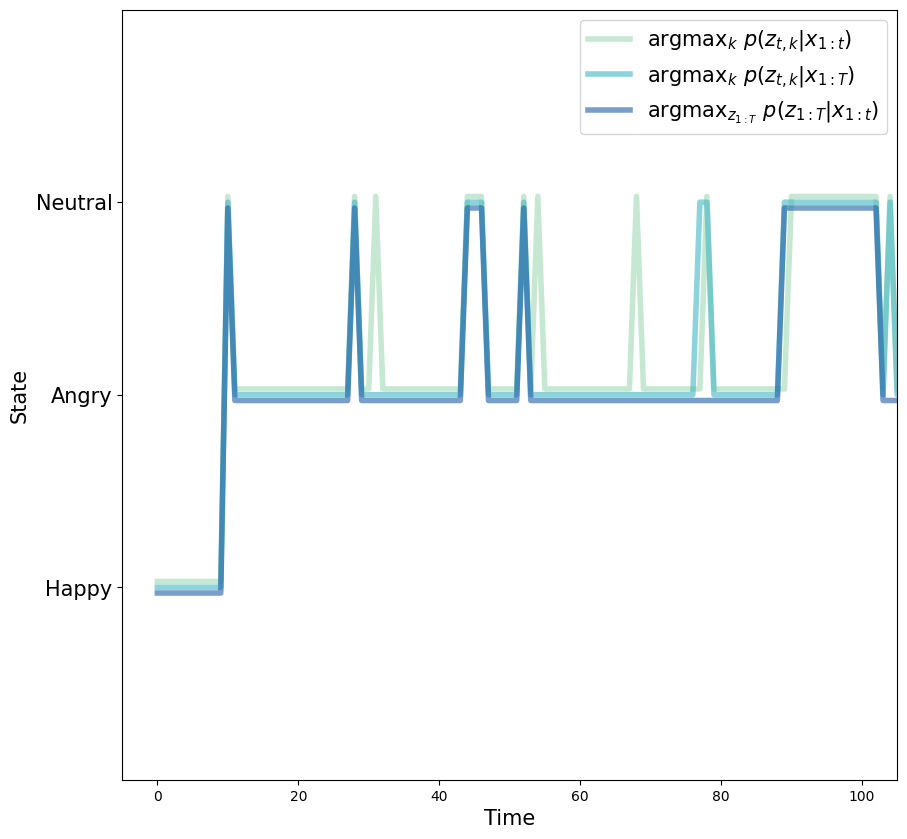

In [46]:
# Let's compare our three options.
dhmm = DiscreteHMM(pi = PI, transition_matrix = A_MAT)

# Start with the argmax of p(z_t|x_{1:t})
alpha_hat, c_t = dhmm.calc_alpha_hat(observations)
beta_hat = dhmm.calc_beta_hat(observations)
p_ztt = dhmm.p_zt_xt(observations, alpha_hat, beta_hat, c_t)
z_max_xt = np.argmax(p_ztt, axis=-1)

# Now the argmax of p(z_t|x_{1:T})
alpha_hat, c_t = dhmm.calc_alpha_hat(observations)
beta_hat = dhmm.calc_beta_hat(observations)
p_ztT = dhmm.p_zt_xT(observations, alpha_hat, beta_hat, c_t)
z_max_xT = np.argmax(p_ztT, axis=-1)

# Now the argmax of log p(z_{1:t}|x_{1:T})
z_oh_max_vt = dhmm.viterbi_algorithm(observations)
z_max_vt = np.argmax(z_oh_max_vt, axis=-1)

# Let's plot our three options
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15

plt.plot(z_max_xt + 3e-2, lw=4, label=r'$\mathrm{argmax}_k \ p(z_{t,k}|x_{1:t})$', color='#a1dab4', alpha=0.6)
plt.plot(z_max_xT, lw=4, label=r'$\mathrm{argmax}_k \ p(z_{t,k}|x_{1:T})$', color='#41b6c4', alpha=0.6)
plt.plot(z_max_vt - 3e-2, lw=4, label=r'$\mathrm{argmax}_{z_{1:T}} \ p(z_{1:T}|x_{1:t})$', color='#225ea8', alpha=0.6)
plt.legend(fontsize=fontsize)
plt.ylim([-1,3])
plt.xlim([-5,105])
plt.xlabel('Time', fontsize=fontsize)
plt.ylabel('State', fontsize=fontsize)
plt.yticks([0,1,2], ['Happy','Angry','Neutral'], fontsize=fontsize)
plt.show()

Your friend is happy to see that all three estimates mostly agree, if a little unsettled by how much time the volunteer was angry.

**Question:** Why does the volunteer spend so much time in the angry state? Make your argument using the transition matrix.



Your friend wants to compare the three possible sequences to find out which one is the most likely. Let’s compare.

In [47]:
prob_z_xt = dhmm.log_p_sequence_xt(observations, p_ztt)
prob_z_xT = dhmm.log_p_sequence_xt(observations, p_ztT)
prob_z_vt = dhmm.log_p_sequence_xt(observations, z_oh_max_vt)

print(f'Log probability of argmax_k p(z_t,k|x_1:t): {prob_z_xt}')
print(f'Log probability of argmax_k p(z_t,k|x_1:T): {prob_z_xT}')
print(f'Log probability of argmax_(z_1:T) p(z_t|x_1:t): {prob_z_vt}')

Log probability of argmax_k p(z_t,k|x_1:t): -2795.802173580815
Log probability of argmax_k p(z_t,k|x_1:T): -2525.4236433318074
Log probability of argmax_(z_1:T) p(z_t|x_1:t): -2514.121012536541


Your friend can see that the Viterbi algorithm gives the most likely sequence, but they don’t understand how it’s possible that $\arg\max_k \, p(z_{t,k} \mid \mathbf{x}_{1:t})$ has zero probability.

**Question:** How is it possible for $\arg\max_k \, p(z_{t,k} \mid \mathbf{x}_{1:t})$ to have zero likelihood?  
Is it possible for the results of the Viterbi algorithm to have this issue?

